In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

In [2]:
# =====================
# 1. Configuración y Carga de Recursos
# =====================
# Detección del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Realizando inferencia en:", device)

# Rutas
experimento = "experimento1 images"
dataset_data_dir = f"/home/mitchellmirano/Desktop/MitchellProjects/H vs J phase diagram/{experimento}"
results_path = "/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/results/SkyrmionClassifier"

Realizando inferencia en: cuda


In [3]:
# Hiperparámetros (deben coincidir con el entrenamiento)
batch_size = 32
img_size = 224
num_workers = 4 # Optimización clave para I/O
pin_memory = torch.cuda.is_available()

In [5]:

with open(Path(results_path)/'classes/id2label_cnn.json', 'r') as f:
# La clave en JSON se lee como string, necesitamos convertirla a int
    id2label = {int(k): v for k, v in json.load(f).items()}
id2label

{0: 'F', 1: 'S', 2: 'Sk', 3: 'V'}

In [9]:
class SkyrmionClassifier(nn.Module):
    def __init__(self):
        super(SkyrmionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (img_size//4) * (img_size//4), 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # salida -> [B, 32, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))   # salida -> [B, 64, H/4, W/4]
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 4
model = SkyrmionClassifier().to(device)

In [10]:
model = torch.load(
    Path(results_path)/'models/model_cnn.pth', 
    weights_only=False  # <--- CAMBIO CLAVE
)
model.to(device)
model.eval() 

print("Modelo cargado exitosamente al deshabilitar weights_only.")

Modelo cargado exitosamente al deshabilitar weights_only.


In [11]:
# =====================
# 2. Transformaciones
# =====================
# Las transformaciones deben ser idénticas a las usadas en el entrenamiento
rgb_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# =====================
# 3. Dataset y DataLoader (Personalizado y Optimizado)
# =====================
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # Listar todas las rutas de imágenes en la inicialización
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        
        # Abrir, asegurar RGB y transformar. Todo esto debe ocurrir en el worker.
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        transformed_image = self.transform(image)

        # Devolvemos la ruta y el tensor de la imagen procesada
        return image_path, transformed_image


my_dataset = MyDataset(root=dataset_data_dir, transform=rgb_transform)

# DataLoader con optimización
data_loader = DataLoader(
    my_dataset, 
    batch_size=batch_size, 
    shuffle=False, # No es necesario mezclar para la inferencia
)

print(f"Dataset de inferencia cargado. Total de imágenes: {len(my_dataset)}")

Dataset de inferencia cargado. Total de imágenes: 10000


In [12]:
# =====================
# 4. Inferencia
# =====================
all_preds_id = []
all_preds_class = []
all_images_path = []
all_probabilities = []

start = datetime.now()

# Bloque torch.no_grad() es esencial para la inferencia
with torch.no_grad():
    pbar = tqdm(data_loader, desc="Inferencia", total=len(data_loader))
    
    # ⚠️ Nota: El DataLoader personalizado devuelve (image_path, transformed_image_tensor)
    for image_paths, images_tensor in pbar: 
        
        # 1. Mover la imagen (tensor) al dispositivo (CUDA/CPU)
        images_tensor = images_tensor.to(device)
        
        # 2. Obtener las salidas del modelo
        outputs = model(images_tensor)
        
        # 3. Calcular las probabilidades (softmax)
        probabilities = F.softmax(outputs, dim=1)
        
        # 4. Obtener el índice de la clase predicha (predicción)
        _, predictions_id = torch.max(outputs, 1) # 'predictions_id' contiene el índice (int)
        
        # 5. Guardar los resultados
        
        # Convertir a numpy/lista en la CPU antes de guardar
        predictions_id_cpu = predictions_id.cpu().tolist()
        probabilities_cpu = probabilities.cpu().numpy()
        
        # Guardar solo el nombre del archivo (más limpio)
        all_images_path.extend([os.path.basename(p) for p in image_paths]) 
        
        # Guardar los ID de las predicciones
        all_preds_id.extend(predictions_id_cpu)
        
        # Guardar las probabilidades (opcional, pero útil)
        all_probabilities.extend(probabilities_cpu)

# Convertir los IDs predichos a nombres de clase
all_preds_class = [id2label[pred_id] for pred_id in all_preds_id]

end = datetime.now()
delta = end - start
total_time = delta.total_seconds()
inference_rate = len(all_images_path) / total_time if total_time > 0 else float('inf')

Inferencia: 100%|██████████| 313/313 [05:20<00:00,  1.02s/it]


In [13]:
import re

def extract_params(file_name):
    # Expresión Regular para capturar los valores
    # Explicación de la Regex:
    # (\w+) : Captura la etiqueta (N, J2, K, H, T) en el grupo 1
    # \s*=\s* : Coincide con el patrón de ' = ' (cero o más espacios, =, cero o más espacios)
    # ([\d\.]+) : Captura el valor numérico (dígitos y puntos decimales) en el grupo 2
    pattern = r"(\w+)\s*=\s*([\d\.]+)"
    
    # Encontrar todas las coincidencias en el nombre del archivo
    matches = re.findall(pattern, file_name)
    
    # Crear un diccionario para almacenar los resultados
    parameters = {}
    for key, value in matches:
        # Convertir los valores a float si es posible, o a int para N
        if key == 'N':
            parameters[key] = int(value)
        else:
            parameters[key] = float(value)

    return parameters

In [14]:

images = [image.split("/")[-1] for image in all_images_path ] 
images

['skyrmionsPlot N = 547 J2 = 0.6272727272727273 K = 0.1 H = 1.7575757575757576 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5060606060606061 K = 0.1 H = 0.787878787878788 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8333333333333333 K = 0.1 H = 0.0 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8878787878787879 K = 0.1 H = 1.7878787878787876 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.43333333333333335 K = 0.1 H = 1.0909090909090908 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6636363636363637 K = 0.1 H = 2.212121212121212 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5606060606060606 K = 0.1 H = 0.30303030303030304 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8515151515151516 K = 0.1 H = 2.090909090909091 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6151515151515152 K = 0.1 H = 0.2727272727272727 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6212121212121212 K = 0.1 H = 1.3636363636363635 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.3 K = 0.1 H = 1.242424242

In [15]:
probs_df = pd.DataFrame(np.array(all_probabilities).round(3), columns=[label for label in list(id2label.values())])
probs_df

,F,S,Sk,V
0,0.999,0.000,0.000,0.001
1,0.998,0.000,0.000,0.002
2,0.000,0.995,0.005,0.000
3,0.002,0.000,0.002,0.996
4,0.999,0.000,0.000,0.001
...,...,...,...,...
9995,0.000,0.006,0.989,0.005
9996,0.000,0.816,0.184,0.000
9997,0.999,0.000,0.000,0.001
9998,0.000,0.006,0.637,0.357


In [16]:
id2label = {int(i):k for i, k in id2label.items()}
id2label

{0: 'F', 1: 'S', 2: 'Sk', 3: 'V'}

In [17]:
df = pd.DataFrame({'experimento': len(images)*[experimento]})
df['image'] = images

Ns = []
J2s = []
Ks = []
Hs = []
Ts = []
for image in df['image']:
    params = extract_params(image)
    Ns.append(params['N'])
    J2s.append(params['J2'])
    Ks.append(params['K'])
    Hs.append(params['H'])
    Ts.append(params['T'])
df['N'] = Ns
df['K'] = Ks
df['T'] = Ts
df['H'] = Hs
df['J2'] = J2s
df = pd.concat([df,probs_df],axis=1)
df['id'] = all_preds_id
df['label'] = all_preds_class #df['id'].map(id2label)
df.to_excel(Path(results_path)/ f'predictions/HvsJ_cnn_inference_{experimento}.xlsx', index=False)
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.999,0.000,0.000,0.001,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.998,0.000,0.000,0.002,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.000,0.995,0.005,0.000,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.002,0.000,0.002,0.996,3,V
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.999,0.000,0.000,0.001,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.000,0.006,0.989,0.005,2,Sk
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.000,0.816,0.184,0.000,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.999,0.000,0.000,0.001,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.000,0.006,0.637,0.357,2,Sk


In [18]:
df = pd.read_excel(Path(results_path)/ f'predictions/HvsJ_cnn_inference_{experimento}.xlsx')
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.999,0.000,0.000,0.001,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.998,0.000,0.000,0.002,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.000,0.995,0.005,0.000,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.002,0.000,0.002,0.996,3,V
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.999,0.000,0.000,0.001,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.000,0.006,0.989,0.005,2,Sk
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.000,0.816,0.184,0.000,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.999,0.000,0.000,0.001,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.000,0.006,0.637,0.357,2,Sk


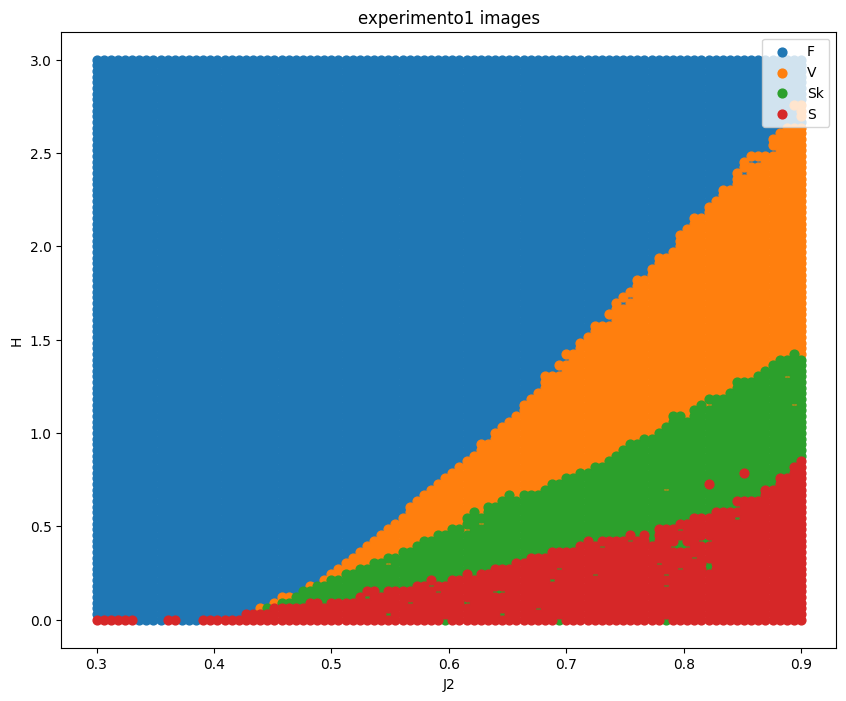

In [20]:
plt.figure(figsize=(10, 8))

for label, count in df['label'].value_counts( ascending=False).items():
    subset = df[df['label'] == label]
    plt.scatter(subset['J2'], subset['H'], label=label, s=40)
    
plt.xlabel('J2')
plt.ylabel('H')
plt.title(experimento)
plt.legend()
plt.savefig(Path(results_path)/f'predictions/HvsJ_cnn_inference_{experimento}.png')
plt.show()

In [22]:
test_df=df[(df["label"]=='Sk') & (df["H"]<0.6) & (df["J2"]>=0.8)].copy()
test_df["images"] = [ os.path.join(dataset_data_dir, img) for img in test_df['image']]
test_df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label,images
27,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8090909090909091 ...,547,0.1,0.01,0.575758,0.809091,0.0,0.094,0.904,0.002,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
45,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8212121212121213 ...,547,0.1,0.01,0.575758,0.821212,0.0,0.030,0.969,0.001,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
980,experimento1 images,skyrmionsPlot N = 547 J2 = 0.803030303030303 K...,547,0.1,0.01,0.545455,0.803030,0.0,0.051,0.949,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
1078,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8151515151515152 ...,547,0.1,0.01,0.575758,0.815152,0.0,0.004,0.995,0.001,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
1737,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8090909090909091 ...,547,0.1,0.01,0.333333,0.809091,0.0,0.262,0.738,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
2265,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8454545454545455 ...,547,0.1,0.01,0.545455,0.845455,0.0,0.163,0.837,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
3378,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8212121212121213 ...,547,0.1,0.01,0.424242,0.821212,0.0,0.377,0.623,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
4096,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8151515151515152 ...,547,0.1,0.01,0.424242,0.815152,0.0,0.466,0.534,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
4285,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8212121212121213 ...,547,0.1,0.01,0.303030,0.821212,0.0,0.382,0.618,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...
4938,experimento1 images,skyrmionsPlot N = 547 J2 = 0.803030303030303 K...,547,0.1,0.01,0.393939,0.803030,0.0,0.143,0.857,0.000,2,Sk,/home/mitchellmirano/Desktop/MitchellProjects/...


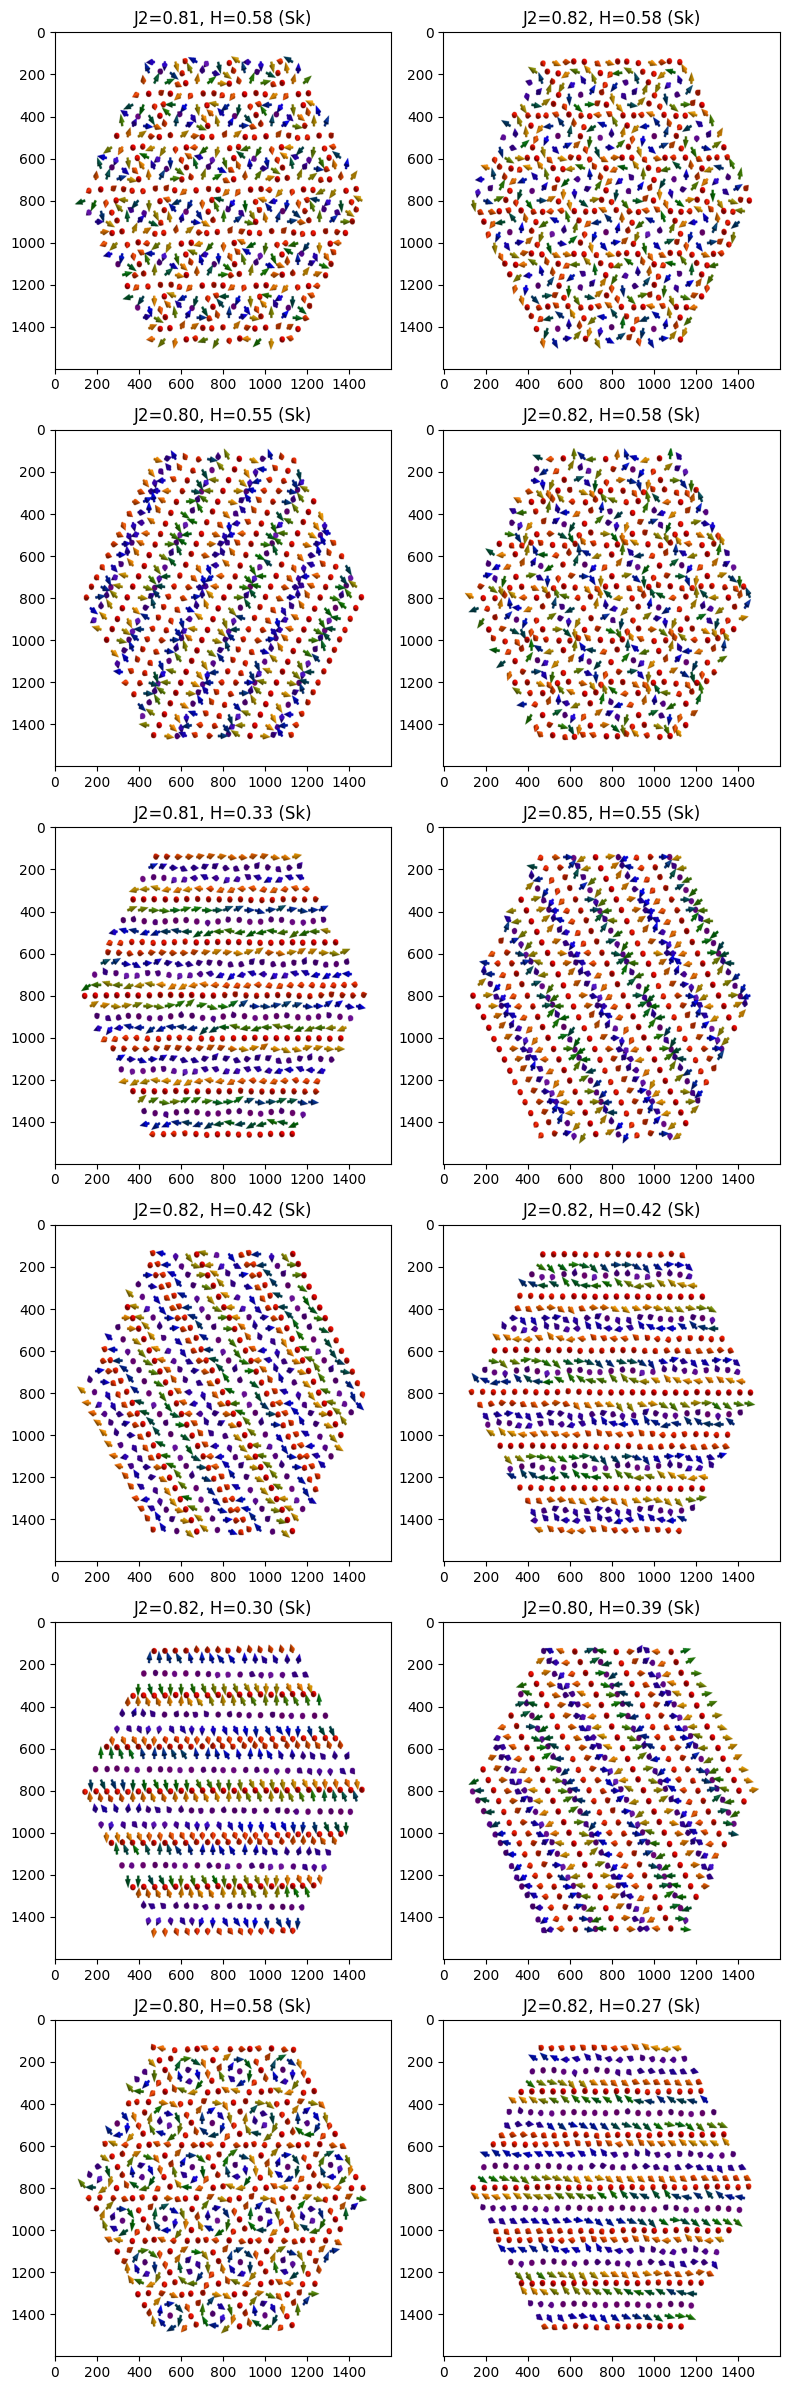

In [23]:
fig, ax = plt.subplots(len(test_df)//2, 2, figsize=(8, 2*len(test_df)))
for i, (index, row) in enumerate(test_df.iterrows()):
    ax[i//2, i%2].imshow(Image.open(row['images']))
    ax[i//2, i%2].set_title(f"J2={row['J2']:.2f}, H={row['H']:.2f} ({row['label']})")
    # ax[i//2, i%2].axis('off')
plt.tight_layout()